### Do NOT click RUN ALL... or else you will spend 20 minutes redefining the embeddings

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from Bio.Seq import Seq
from transformers import TFBertModel, BertTokenizer,BertConfig
import re
import pickle
import sys
import gc
import os
import math
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE
import random

# np.random.seed(42)
# tf.random.set_seed(42)
# os.environ['PYTHONHASHSEED']=str(42)
tf.keras.utils.set_random_seed(42)


# Defining

Code for ProtBERT and BFD

In [ ]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False)
embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-01-28 08:24:39.047515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-28 08:24:39.047677: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorc

In [ ]:
def get_embeddings(sequence_list):
    # tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False )
    # embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)
    sequence_list = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequence_list]
    ids = tokenizer.batch_encode_plus(sequence_list, add_special_tokens=True, padding=True, return_tensors="tf")
    input_ids = ids['input_ids']
    attention_mask = np.asarray(ids['attention_mask'])
    embedding = np.asarray(embedding_model(input_ids)[0])
    print(np.shape(input_ids))
    average_embeddings = []
    for seq_num in range(len(embedding)):

        seq_len = (attention_mask[seq_num] == 1).sum()
        
        # seq_len = (len(attention_mask[seq_num]))
        residues = embedding[seq_num][1:seq_len-1]
        average = np.mean(residues, axis=0)
        average_embeddings.append(average)
    
    del residues
    del average
    del ids
    del sequence_list
    del embedding
    del input_ids
    del attention_mask
    gc.collect()

    return np.asarray(average_embeddings)

In [ ]:
sequences_Example = ["A E T C Z A O","S K T Z P"] # REMEMBER SPACING

In [5]:
average_embeddings = get_embeddings(sequences_Example)
# print(residue_embeddings)

(2, 9)


In [6]:
tf.__version__

'2.10.0'

# Data Formatting

In [7]:
# shutil.copy("../Data/HIV/heavy_seqs_aa.fasta", "../Data/HIV/heavy_seqs_aa.txt")
# OR
# Run the following too when new download
# awk '/^>/ {printf("\n%s\n",$0);next; } { printf("%s",$0);}  END {printf("\n");}' < file.fa > out.txt
# Then, delete the first empty line

In [8]:
dummy = []
head = []
with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    # count = 0
    for i in myfile:
        # if count <= 1:
        #     print(i)
        #     if i.find(">") == -1 & i.find("-") == -1:
        #         print(Seq.translate(i.strip()))
        #     count+=1
        dummy.append(i)
    np.random.shuffle(dummy)
    
    for i in dummy:
        if i.find(">") == -1 & i.find("-") == -1 & i.find("N") == -1: # These conditions must be met for a valid sequence, the longest was 141. However, there is no 141 sequence for hiv, the greatest is 138, so we go with that
            aa_sequence = Seq.translate(i.strip())
            if (len(aa_sequence) <= 138) & (len(aa_sequence) >= 100):
                head.append(aa_sequence)
                if len(head) >= 41000:
                    break
print(head[:5], len(head))
healthy_sequences = head

/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


['EVQLVQSGPEVKKPGSSVKVSCKASGGTFSNFAFSWVRQAPGQGLEWMGSVILHLGTSTYAQKFQGRVTITADESTSAAFMDLNALTSDDTAVYYCARVVAVPGRVPYWFDPWGQGTLVTVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARVPPTSTVTTLGDDYWGQGTLVTVSS', 'QVQLVQSGPEVKKPGASVRVSCKPSGYPFSNYGISWMRQAPGQGLEWMGWVNIDKGNTKYAQKFQDRVTMTTDTSSSTVYLELRSLRSDDTALYYCARERGGYRYGDYWGQGTLVIVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEIKHSGSTNYIPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCASRAGAAAASWGQGTLVTVSS', 'SETLSLTCAVHGGSFSDYYWTWIRQPPGKGLEWIGEINHRGGTNYNPSLKSRLNILVDTSKSQFSLKLSSVTAADTAVYFCARERFILIRGLTKYYYYMDVWGKGTTVTVS'] 41000


In [9]:
dummy = []
head = []
flag = False
with open("../Data/HIV/heavy_hiv.txt") as myfile:
    for i in myfile:
        dummy.append(i)
    for i in dummy:
        # if flag == True:
        #     flag = False
        #     continue
        # if i.find("partial") != -1:
        #     flag = True
        #     continue
        if i.find(">") == -1 & i.find("-") == -1 & i.find("X") == -1:
            if (len(i) <= 138) & (len(i) >= 100):
                if i not in head:
                    head.append(i)
    np.random.shuffle(head)
print(head[:5], len(head))
hiv_sequences = head

dummy = []
head = []
with open("../Data/HIV/heavy_seqs_aa.txt") as myfile:
    for i in myfile:
        dummy.append(i)
    for i in dummy:
        # if flag == True:
        #     flag = False
        #     continue
        # if i.find("partial") != -1:
        #     flag = True
        #     continue
        if i.find(">") == -1 & i.find("-") == -1 & i.find("X") == -1:
            if (len(i) <= 138) & (len(i) >= 100):
                if i not in head:
                    head.append(i)
    np.random.shuffle(head)
print(head[:5], len(head))

hiv_sequences = np.concatenate((hiv_sequences, head))

hiv_sequences = list(dict.fromkeys(hiv_sequences))

['QVQLVESGGGLVKPGGSLRLSCAASGFSFSDYYMSWIRQAPGKGLEWVSYIRSSGGSIYYADSVKGRFTIFWDNAKNSVLLQMNRLRAEDTAVYYCARGNGYWYFDLWGRGTLVTVSS\n', 'QVQLVESGGGVVQPGGSLRVSCAASGFRFSSYGMHWVRQAPGKGLEWVAFIRYDGSNRFYADSVKGRFTISRDNSKNTLYVQMNSLRAEDTAVYYCAKEGNWNDLKYHFDHWGQGTLVSVSS\n', 'QVQLVQSGAEVKKPGASVKVSCKASGYTFASYAISWVRQAPGQGPEWMGWISAYSGDTKYVQFLQGRVTITTDTSTSTASMELRSLRSDDTAVYYCARALHPVTIFGVGCLDSWGQGTLVTVSS\n', 'EVQLVESGGGLEQPGRSLSLSCAASGFSFGEYAMSWVRQAPGKGLEWVGFIRSKAYGGTTEYAASVKGRVTISRDDSRSIAYLQMNSLKTEDTAVYYCARGASLEWLLSVSDYYYMDVWGKGTTVTVSS\n', 'EVRLVQSGAVLRKPGSSVKISCRASGYDFREISLHWVRLTPARGFEWIGWIKPRWGAVGYARQLQGRVTLTRQLSQDPDDPDWGIGYMELSGLTSADSAEYFCVRRGPCDYCGDFVWQYWGQGTVVVVS\n'] 12534
['QVHLVQSGTEVKKPGASVTVSCKASGYSFTGYYLHWVRQAPGQGLEWMGWINPNSGGTYYAQNFQARVTMTRDTSISTVYMDLSRLRSDDTAVYYCVRRAVLTALPPRYYFDFWGQGTLVTVSS\n', 'EVQLVESGGGLVRPGGSLRLSCAASGFTFSDFDFHWVRQVAGKGLQWVAAIGGVRDTYYAESVKGRFTISRNNGGNSLYLQMTGLRDEDTAVYYCVKGPASGWWYHDYYGLYVWGQGTTVTVSS\n', 'QVQLVQSGGGLVKPGGSLTPSCVTSGFTFSNTWMSWVRQTPGKGLEWVARISRVGDGPIIDYAAPVKGRFIISRDDSRN

In [10]:
# print(healthy_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(hiv_sequences, key=len)))
print(len(healthy_sequences))
print(len(hiv_sequences))
# print(hiv_sequences)

138
138
41000
12662


In [11]:
del head
del myfile
del dummy
gc.collect()

0

In [12]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

# Preprocessing

In [13]:
if os.path.exists('hiv_binary_embeddings') == False:
    os.mkdir('hiv_binary_embeddings')

In [14]:
number_param_hiv = math.ceil(len(hiv_sequences)/3000)

for i in range(number_param_hiv):
    hiv_sequences_new = [(" ".join(s)) for s in hiv_sequences][round(len(hiv_sequences) * (1/number_param_hiv) * i):round(len(hiv_sequences) * (1/number_param_hiv) * (i+1))]
    hiv_average_embeddings = get_embeddings(hiv_sequences_new)

    with open("hiv_binary_embeddings/hiv_" + str(i) + ".pkl", "wb") as f:
        pickle.dump(hiv_average_embeddings, f)

    del hiv_sequences_new
    del hiv_average_embeddings
    gc.collect()

In [ ]:
number_param_healthy = math.ceil(len(healthy_sequences)/3000)

for i in range(number_param_healthy):
    healthy_sequences_new = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * (1/number_param_healthy) * i):round(len(healthy_sequences) * (1/number_param_healthy) * (i+1))]
    healthy_average_embeddings = get_embeddings(healthy_sequences_new)

    with open("hiv_binary_embeddings/healthy_" + str(i) + ".pkl", "wb") as f:
        pickle.dump(healthy_average_embeddings, f)
    f.close()

    del healthy_sequences_new
    del healthy_average_embeddings
    gc.collect()

(2929, 139)
(2928, 136)
(2929, 137)
(2928, 139)
(2929, 139)
(2928, 140)
(2929, 137)
(2929, 140)
(2928, 136)
(2929, 138)
(2928, 139)
(2929, 139)
(2928, 140)
(2929, 135)


# Loading

In [2]:
hiv_average_embeddings = [[None] * 1024]

In [3]:
number_param_hiv = 5
for i in range(1, number_param_hiv):
    with open("hiv_binary_embeddings_old/hiv_" + str(i) + ".pkl", "rb") as f:
        hiv_temp = pickle.load(f)
        hiv_average_embeddings = np.concatenate((hiv_average_embeddings, hiv_temp))
    f.close()

hiv_average_embeddings = np.delete(hiv_average_embeddings, 0, 0)

In [4]:
healthy_average_embeddings = [[None] * 1024]

In [5]:
number_param_healthy = 5 #14
for i in range(1, number_param_healthy):
    with open("hiv_binary_embeddings_old/healthy_" + str(i) + ".pkl", "rb") as f:
        healthy_temp = pickle.load(f)
        healthy_average_embeddings = np.concatenate((healthy_average_embeddings, healthy_temp))
    f.close()

healthy_average_embeddings = np.delete(healthy_average_embeddings, 0, 0)

In [6]:
print(healthy_average_embeddings.shape)

(12662, 1024)


In [7]:
healthy_lables = [0] * 12662 # 41000
hiv_lables = [1] * 12662

# Model 3: Averaging Embeddings

In [8]:
X = np.concatenate((healthy_average_embeddings[:12662], hiv_average_embeddings))
y = np.concatenate((healthy_lables, hiv_lables))

In [9]:
# del healthy_average_embeddings
del hiv_average_embeddings
gc.collect()

0

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [11]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

20511
2533
2280


In [12]:
print(len([i for i in y_test if i == 0]))
print(len([i for i in y_test if i == 1]))
print(len([i for i in y_val if i == 0]))
print(len([i for i in y_val if i == 1]))

1278
1255
1097
1183


In [13]:
# val_set = zip(X_val, y_val)
# new_y_val = []
# new_X_val = []
# count = 0
# for i in val_set:
#     if i[1] == 1:
#         new_X_val.append(i[0])
#         new_y_val.append(i[1])
#     if i[1] == 0 and count < 1156:
#         new_X_val.append(i[0])
#         new_y_val.append(i[1])
#         count+=1

# c = list(zip(new_X_val, new_y_val))

# # random.shuffle(c)

# X_val, y_val = zip(*c)
# y_val = np.array(y_val)
# # print(y_val)

In [14]:
# test_set = zip(X_test, y_test)
# new_y_test = []
# new_X_test = []
# count = 0
# for i in test_set:
#     if i[1] == 1:
#         new_X_test.append(i[0])
#         new_y_test.append(i[1])
#     if i[1] == 0 and count < 1253:
#         new_X_test.append(i[0])
#         new_y_test.append(i[1])
#         count+=1

# c = list(zip(new_X_test, new_y_test))

# # random.shuffle(c)

# X_test, y_test = zip(*c)
# y_test = np.array(y_test)
# # print(y_test)

In [15]:
# This stuff was not ran

In [15]:
X_train = np.concatenate((X_train, healthy_average_embeddings[12663:13000]))
y_train = np.concatenate((y_train, [0] * len(healthy_average_embeddings[12663:13000])))

In [16]:
for i in y_train:
    print(i)

1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0


In [17]:
del X
del y
gc.collect()

0

### Using SMOTE

In [18]:
# print(len([i for i in y_train if i == 0]))
# sm = BorderlineSMOTE(random_state=42, sampling_strategy=1.0)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print(X_train.shape)

10224


In [ ]:
print(len([i for i in y_train if i == 0]))
sm = SMOTE(random_state=42, sampling_strategy=1.0)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(X_train.shape)

10287


In [ ]:
for i in y_train:
    print(i)

0
0
0
1
1
0
0
0
1
0
0
0
0
1
0
1
1
0
0
0
1
1
0
1
1
0
0
1
0
1
1
1
0
0
0
0
0
1
0
0
1
0
1
0
1
1
1
0
0
0
1
1
0
0
1
0
1
0
0
0
1
1
1
0
1
0
0
1
1
1
1
0
1
0
1
1
1
0
0
0
0
0
0
1
0
0
0
0
1
1
0
0
0
0
0
0
1
1
0
0
0
1
0
1
1
1
0
0
1
1
1
1
1
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
1
0
1
1
1
1
1
0
1
0
1
0
0
0
1
1
1
1
0
1
0
1
1
0
1
0
1
1
1
1
0
0
0
1
0
0
0
1
0
0
1
1
0
0
0
1
0
0
0
1
1
1
1
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
1
0
1
0
1
0
1
0
0
1
0
0
0
0
0
1
1
1
1
1
1
1
0
0
0
1
1
0
1
1
1
0
0
1
1
0
0
1
1
0
0
0
0
0
0
0
1
1
1
0
1
0
0
1
1
1
1
0
0
1
0
0
0
0
1
1
1
0
1
1
1
1
0
0
1
1
0
1
0
0
1
1
0
1
0
0
0
1
0
0
1
1
0
0
1
0
1
0
0
1
0
1
0
0
1
1
0
0
1
0
0
1
1
0
1
0
0
0
1
1
0
1
0
0
0
1
1
1
1
0
1
0
0
0
0
1
1
1
0
0
0
1
0
0
1
1
1
0
0
0
0
1
1
1
1
0
1
1
1
0
1
0
0
1
1
0
0
1
1
0
1
1
1
0
1
1
0
0
0
0
1
1
1
0
0
1
0
0
0
1
0
0
1
1
1
1
0
0
1
0
0
0
1
1
0
0
1
0
1
0
0
1
0
0
1
0
0
0
1
1
0
0
0
1
0
1
1
1
0
0
1
1
1
1
1
0
0
0
0
0
1
1
1
1
1
0
0
0
0
1
0
1
0
0
0
1
1
0
0
1
1
0
0
1
1
0
1
0
0
0
0
1
0
0
1
1
1
0
1
0
1
1
1
0
1
0
0
1
1
1
0
1
1
0
0
1
0
1
0
0
0
0
0
1


In [ ]:
# c = list(zip(X_train, y_train))

# random.shuffle(c)

# X_train, y_train = zip(*c)
# y_train = np.array(y_train)
# for i in y_train:
#     print(i)

### Using Borderline SMOTE

In [22]:
# print(len([i for i in y_train if i == 0]))
# sm = BorderlineSMOTE(random_state=41, sampling_strategy=1.0)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print(X_train.shape)

### Model Evaluation

In [17]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
X_val = np.asarray(X_val).astype('float32')

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1024,)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(784, activation='relu'),
  tf.keras.layers.Dropout(0.5, seed=42),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(384, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5, seed=42),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  # tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.1, seed=42),
  # tf.keras.layers.Dense(8, activation='relu'),
  # tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(1024,)),
#   tf.keras.layers.Dense(1024, activation='relu'),
#   tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dropout(0.5, seed=42),
#   tf.keras.layers.Dense(256, activation='relu'),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.5, seed=42),
#   tf.keras.layers.Dense(64, activation='relu'),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(16, activation='relu'),
#   # tf.keras.layers.Dense(8, activation='relu'),
#   # tf.keras.layers.Dense(4, activation='relu'),
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ])

model.summary()

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 784)               803600    
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dense_3 (Dense)             (None, 384)               196992    
                                        

2023-01-28 21:16:33.286388: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-28 21:16:33.286536: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [16]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=150,
    mode='auto',
    restore_best_weights=True,
)

In [17]:
history = model.fit(X_train, y_train, epochs=1000, validation_data = (X_val, y_val), callbacks=[es])

Epoch 1/1000


2023-01-28 21:16:34.372162: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-28 21:16:34.727131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


641/641 [==============================] - ETA: 0s - loss: 0.3867 - accuracy: 0.7924

2023-01-28 21:16:42.111840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


641/641 [==============================] - 8s 12ms/step - loss: 0.3867 - accuracy: 0.7924 - val_loss: 0.3391 - val_accuracy: 0.8285
Epoch 2/1000
641/641 [==============================] - 7s 11ms/step - loss: 0.3031 - accuracy: 0.8493 - val_loss: 0.2999 - val_accuracy: 0.8478
Epoch 3/1000
641/641 [==============================] - 7s 11ms/step - loss: 0.2876 - accuracy: 0.8587 - val_loss: 0.2871 - val_accuracy: 0.8478
Epoch 4/1000
641/641 [==============================] - 7s 11ms/step - loss: 0.2788 - accuracy: 0.8623 - val_loss: 0.3026 - val_accuracy: 0.8535
Epoch 5/1000
641/641 [==============================] - 7s 11ms/step - loss: 0.2642 - accuracy: 0.8727 - val_loss: 0.2774 - val_accuracy: 0.8684
Epoch 6/1000
641/641 [==============================] - 8s 13ms/step - loss: 0.2613 - accuracy: 0.8729 - val_loss: 0.2775 - val_accuracy: 0.8689
Epoch 7/1000
641/641 [==============================] - 8s 13ms/step - loss: 0.2427 - accuracy: 0.8816 - val_loss: 0.2753 - val_accuracy: 0.870

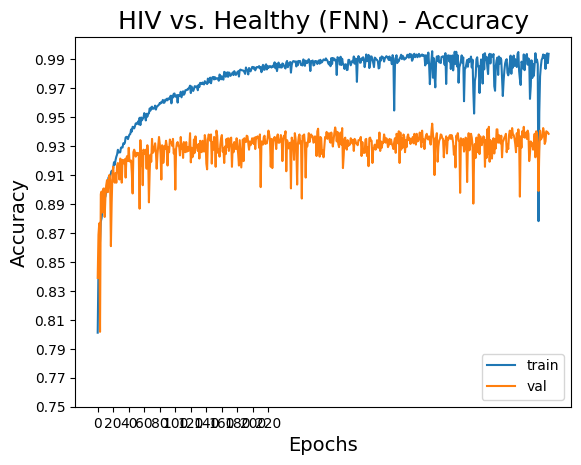

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('HIV vs. Healthy (FNN) - Accuracy', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.yticks(np.arange(0.75, 1.0, 0.02))
plt.xticks(np.arange(0, 240, 20.0))
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Model 3 Testing

In [31]:
model.save("hiv_model.h5")

In [29]:
with open('hiv_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [18]:
model.evaluate(X_test, y_test)

2023-01-29 17:11:33.778358: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-29 17:11:33.937098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 3s 14ms/step - loss: 0.6930 - accuracy: 0.9281


[0.6930302977561951, 0.9281484484672546]

In [13]:
model = tf.keras.models.load_model("hiv_model.h5")

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-01-29 17:10:15.873579: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-29 17:10:15.873823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [38]:
y_pred = []
y_true = y_test

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

1/1 [==============================] - 0s 15ms/step


2023-01-26 22:45:38.786170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 21ms/step


[array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([

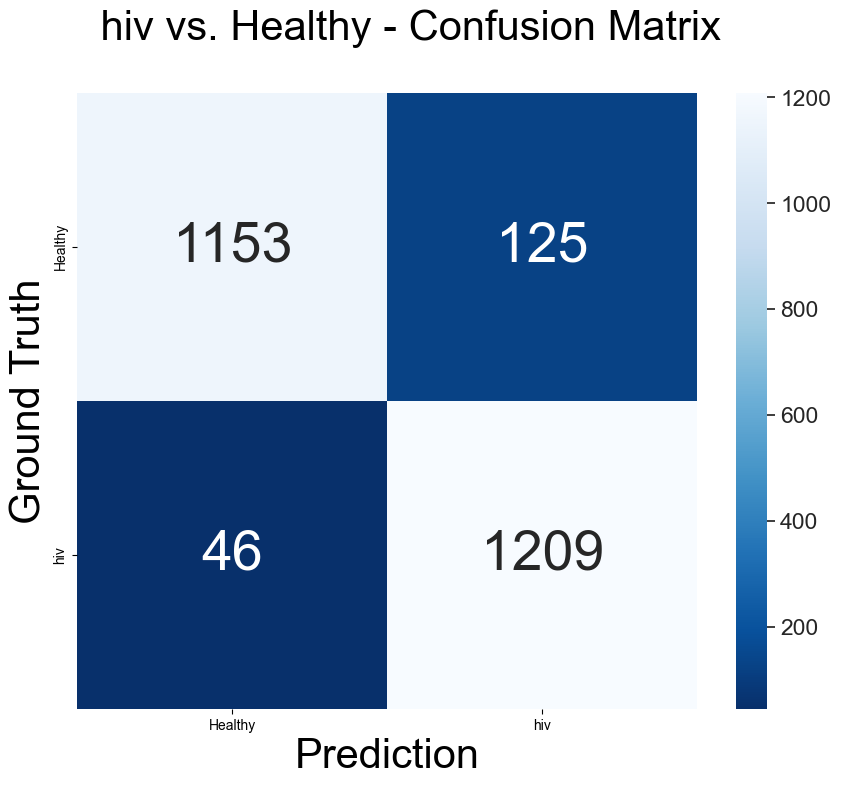

tf.Tensor(
[[1153  125]
 [  46 1209]], shape=(2, 2), dtype=int32)


In [39]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
plt.title('    hiv vs. Healthy - Confusion Matrix\n', fontsize=30)
sns.set(font_scale=1.5)

cmap = sns.color_palette("Blues_r", as_cmap=True)

sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "hiv"],
            yticklabels=["Healthy", "hiv"],
            annot=True, fmt='g', annot_kws={"size":40}, cmap=cmap)
plt.xlabel('Prediction', fontsize=30)
plt.ylabel('Ground Truth', fontsize=30)
plt.show()

print(confusion_mtx)

In [40]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

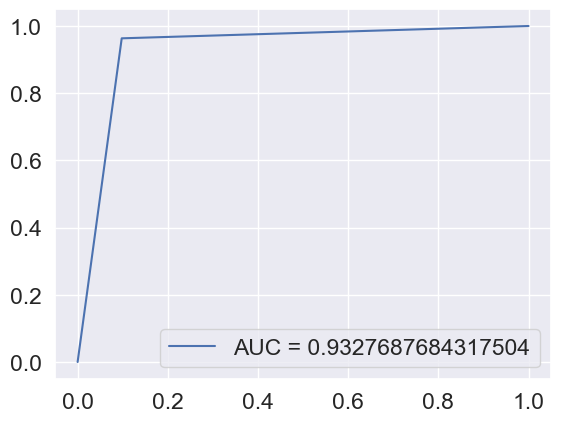

In [41]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()